<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm


# 1. SINDy (sparse identification of the non-linear dynamics) in Groud Truth Coordinates z

1.1 Simulation


In [2]:
# Define the pendulum_rhs function
def pendulum_rhs(z, dzdt, coefficients, terms):
    return np.dot(terms(z), coefficients)

In [3]:
# Define the pendulum_ode_step function
def pendulum_ode_step(y, t, coefficients, terms):
    D = len(y) // 2
    z_values = y[:D]
    dzdt_values = y[D:]

    # Evaluate rhs using the current terms
    rhs = pendulum_rhs(z_values, dzdt_values, coefficients, terms)

    # Check if rhs is 1-dimensional or 2-dimensional
    if np.ndim(rhs) == 1:
        dydt = np.concatenate([dzdt_values, rhs])
    else:
        dydt = np.concatenate([dzdt_values, rhs[1]])

    return dydt

In [4]:
# Function to simulate the pendulum using odeint
def simulate_pendulum(y0, coefficients, terms, T, dt):
    # Call odeint with the pendulum_ode_step function
    result = odeint(pendulum_ode_step, y0, np.arange(0, T, dt), args=(coefficients, terms))

    return result

(100, 2)
(100, 1)


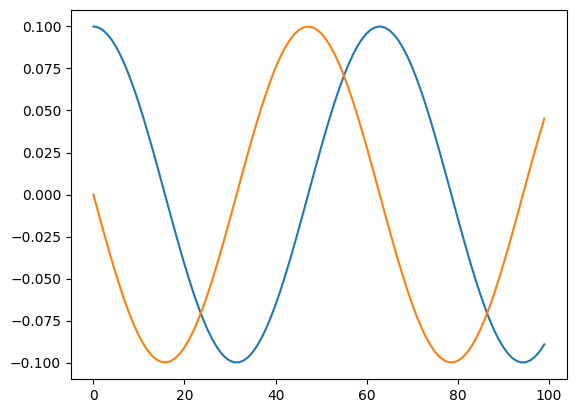

In [5]:
# checking something
D = 1
L = 1
z0 = np.array([0.1])
dz0 = np.array([0.0])
coefficients = np.array([[-1.0]])

# Define terms as a vector of functions (sine function in this case)
terms = lambda z: np.sin(z)

T = 10.0
dt = 0.1
y0 = np.concatenate([z0, dz0])

result = simulate_pendulum(y0, coefficients, terms, T, dt)
plt.plot(result); print(np.shape(result)); print(np.shape(result[:,:D]))

In [55]:
def create_pendulum_data(z0_min, z0_max,
                         dz0_min, dz0_max,
                         coefficients, terms,
                         T, dt, N,
                         embedding=None, rejection=True, Dim=1):
    data_dict = {}

    for sim_run_num in tqdm(range(N), desc="Simulations"):
        while True:
            z0 = np.array([np.random.uniform(z0_min, z0_max)])
            dz0 = np.array([np.random.uniform(dz0_min, dz0_max)])

            if not rejection:
                break  # No rejection, proceed with the simulation

            angular_momentum = 0.5 * (dz0 ** 2) - np.cos(z0)
            #print("angular_momentum", np.abs(angular_momentum))

            if np.abs(angular_momentum) <= 0.99:
                break  # Angular momentum condition satisfied, proceed with the simulation

        simulation_result = simulate_pendulum(np.concatenate([z0, dz0]), coefficients, terms, T, dt)
        # D=np.shape(simulation_result)[1]//2
        # print("Dim is:", Dim)
        second_derivative = pendulum_rhs(simulation_result[:,:Dim], simulation_result[:,Dim:],
                                         coefficients, terms)

        if embedding is not None:
            # Add code for artificial embedding (needed later)
            pass

        data_dict[sim_run_num+1]={"z":simulation_result[:, :Dim],
                                  "dzdt":simulation_result[:, Dim:],
                                  "d2zdt":second_derivative}

        #data.append((simulation_result[:, :Dim], simulation_result[:, Dim:], second_derivative))#[D:]))

    return data_dict



In [56]:
z0_min = -np.pi
z0_max = np.pi
dz0_min = -2.1
dz0_max = 2.1
coefficients = np.array([[-1.0]])
terms = lambda z: np.sin(z)

T = 50.0
dt = 0.1
N = 100# number of simulation runs
embedding = None
rejection = True

training_data_dict = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max,
                                     coefficients, terms, T, dt, N, embedding, rejection)

time=np.arange(0,T,step=dt)

# print("training_data dict:")
# print(training_data_dict)

Simulations: 100%|██████████| 100/100 [00:01<00:00, 57.24it/s]


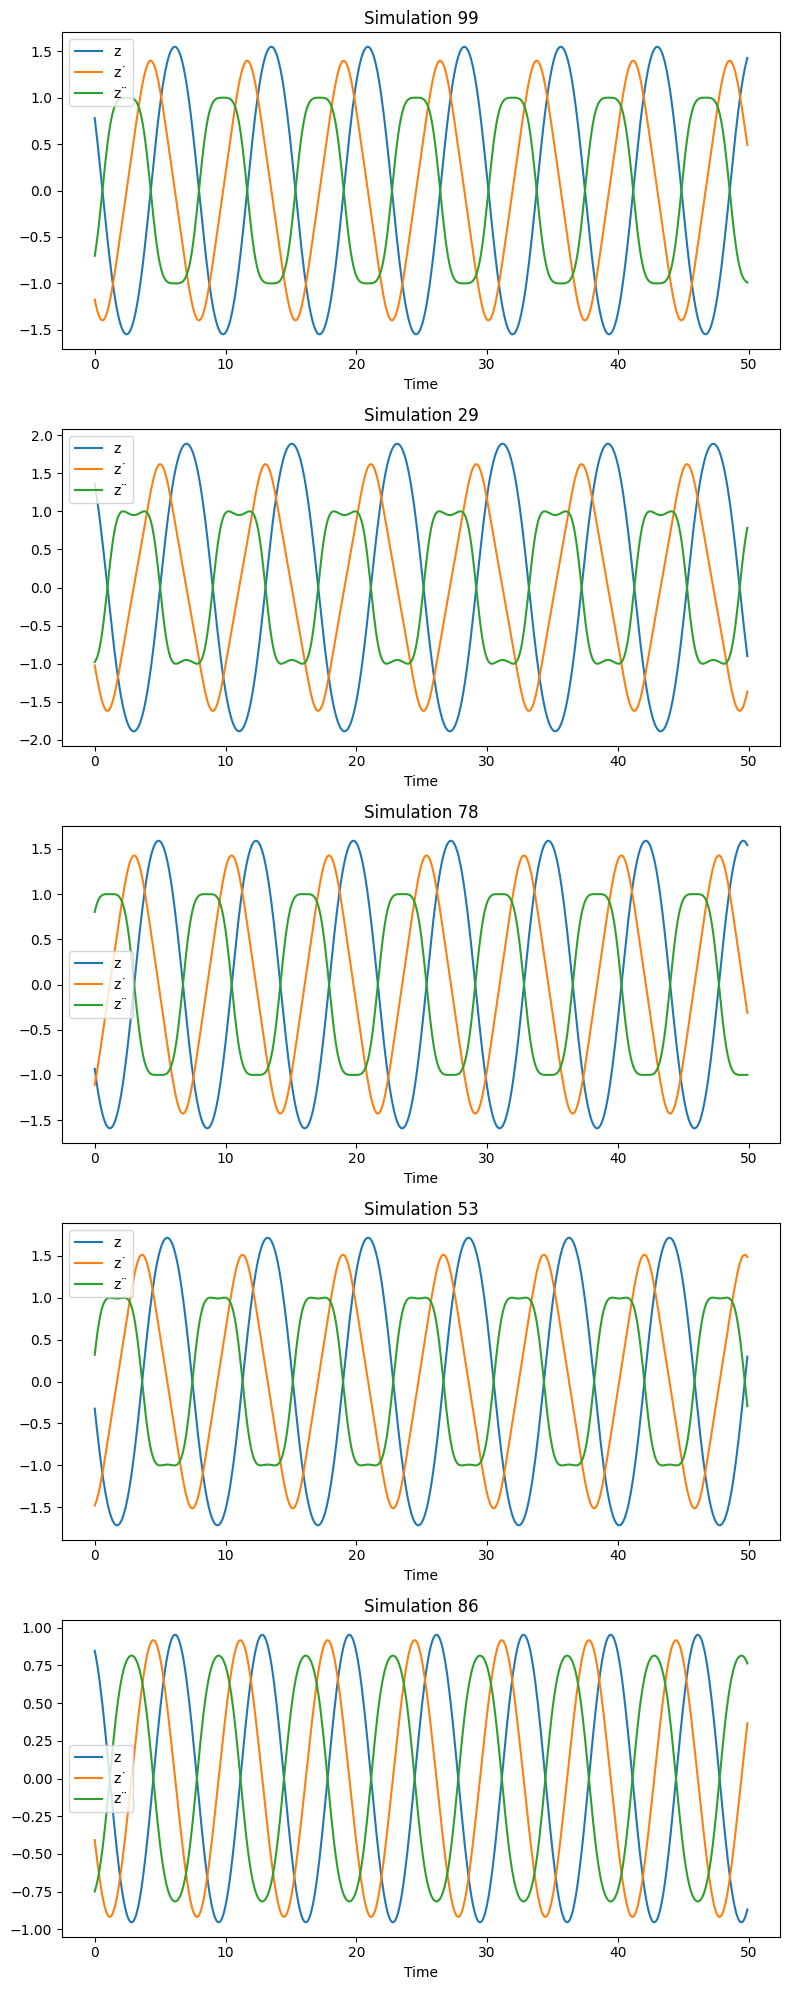

In [57]:
import matplotlib.pyplot as plt

# Choose 5 simulations randomly
selected_simulations = np.random.choice(N, 5, replace=False)

# Plot the selected simulations
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

for i, sim_num in enumerate(selected_simulations):
    time_points = np.arange(0, T, step=dt)  # Assuming 'time' is not included in data_dict
    z_values = training_data_dict[sim_num+1]['z']  # zt
    dzdt_values = training_data_dict[sim_num+1]['dzdt']  # z˙t
    d2zdt_values = training_data_dict[sim_num+1]['d2zdt']  # z¨t

    # Plot z, z˙, and z¨ on the same plot
    axs[i].plot(time_points, z_values, label='z')
    axs[i].plot(time_points, dzdt_values, label='z˙')
    axs[i].plot(time_points, d2zdt_values, label='z¨')
    axs[i].set_title(f'Simulation {sim_num + 1}')
    axs[i].set_xlabel('Time')
    axs[i].legend()

plt.tight_layout()
plt.show()




1.2 Implementation and Training

In [58]:
def sin_term(z):
    return np.sin(z)

def cos_term(z):
    return np.cos(z)

def square(z):
  return z*z

def z_times_dzdt(z,dzdt):
  return z * dzdt


def term_vector(z,dzdt):
  return np.array([1.0, z, dzdt, sin_term(z),
                   square(z), z_times_dzdt(z,dzdt),
                   z*sin_term(z), square(dzdt),
                   dzdt * sin_term(z),
                   sin_term(z)*sin_term(z)
                   ])

# Everything below is not important

In [ ]:
# import numpy as np
# from scipy.integrate import odeint
# import matplotlib.pyplot as plt

# # Define the ODE system
# def my_ode(y, t):
#     dydt = -2 * y  # Example: simple exponential decay
#     return dydt

# # Initial condition
# y0 = 1.0

# # Time points
# t = np.linspace(0, 5, 101)

# # Solve the ODE using odeint
# solution = odeint(my_ode, y0, t)

# # Plot the solution
# plt.plot(t, solution)
# plt.xlabel('Time')
# plt.ylabel('y(t)')
# plt.title('ODE Solution')
# plt.show()
